#Tugas 1 - Klasifikasi Citra

##1. Import library yang diperlukan

In [1]:
!pip install split-folders

In [2]:
pip install numpy matplotlib opencv-python

In [3]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import splitfolders

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

In [4]:
!pip freeze | grep tensorflow

tensorflow==2.15.0
tensorflow-datasets==4.9.4
tensorflow-estimator==2.15.0
tensorflow-gcs-config==2.15.0
tensorflow-hub==0.15.0
tensorflow-io-gcs-filesystem==0.34.0
tensorflow-metadata==1.14.0
tensorflow-probability==0.22.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##2. Load dan unzip data rps.zip dari link dataset yang diberikan

In [6]:
datasetpath = r'/content/drive/My Drive/Colab Notebooks/Machine Learning/Modul 5/Dataset/rps'

In [7]:
# list class dalam dataset
classes = os.listdir(datasetpath)
num_classes = len(classes)
print(f"{num_classes} classes consisiting of: {classes}")

4 classes consisiting of: ['scissors', 'rock', 'paper', 'augmented_images']


##3. Lakukan splitting folder yang mencakup folder train, val, dan test

In [ ]:
paper_path = os.path.join(datasetpath, classes[0])
rock_path = os.path.join(datasetpath, classes[1])
scissors_path = os.path.join(datasetpath, classes[2])

In [ ]:
splitfolders.ratio(datasetpath, output= r"/content/drive/My Drive/Colab Notebooks/Machine Learning/Modul 5/Dataset/rps/augmented_images", seed=42, ratio=(.7,.25,.05), group_prefix=None, move=False)


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  3.16 files/s]
Copying files: 10 files [00:01, 10.29 files/s]
Copying files: 17 files [00:01, 17.98 files/s]
Copying files: 26 files [00:01, 29.03 files/s]
Copying files: 33 files [00:01, 36.46 files/s]
Copying files: 41 files [00:01, 44.66 files/s]
Copying files: 50 files [00:01, 53.90 files/s]
Copying files: 58 files [00:01, 58.87 files/s]
Copying files: 66 files [00:01, 63.89 files/s]
Copying files: 74 files [00:01, 65.30 files/s]
Copying files: 83 files [00:02, 71.17 files/s]
Copying files: 91 files [00:02, 71.88 files/s]
Copying files: 101 files [00:02, 77.43 files/s]
Copying files: 110 files [00:02, 74.47 files/s]
Copying files: 119 files [00:02, 76.90 files/s]
Copying files: 127 files [00:02, 75.80 files/s]
Copying files: 136 files [00:02, 77.99 files/s]
Copying files: 144 files [00:02, 76.78 files/s]
Copying files: 153 files [00:02, 78.33 files/s]
Copying files: 161 files [00:03, 77.51 files/s]
Copying fi

##4. Melakukan Exploration Data Analyst

In [8]:
# Fungsi untuk memuat dataset citra dari tiga folder kelas
def load_images_from_folder(root_folder):
    classes = os.listdir(root_folder)
    images = []
    labels = []

    for class_name in classes:
        class_folder = os.path.join(root_folder, class_name)
        for filename in os.listdir(class_folder):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is not None:
                images.append(img)
                labels.append(class_name)

    return images, labels

In [9]:
images, labels = load_images_from_folder(datasetpath)

In [10]:
# Statistik sederhana tentang dataset citra
num_images = len(images)
unique_labels = np.unique(labels)

print(f"Jumlah citra: {num_images}")
print(f"Jumlah kelas: {len(unique_labels)}")
print(f"Kelas: {unique_labels}")

Jumlah citra: 2520
Jumlah kelas: 3
Kelas: ['paper' 'rock' 'scissors']


Copying files: 2141 files [28:36,  1.25 files/s]


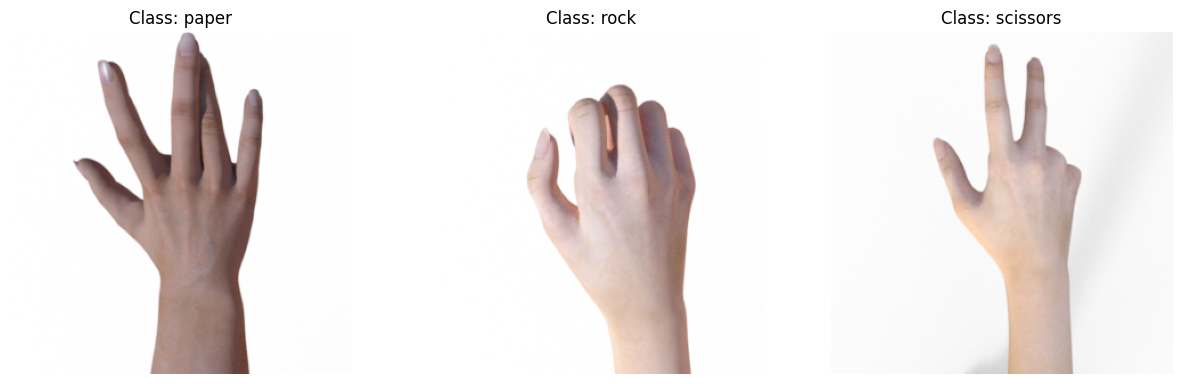

In [ ]:
# Menampilkan beberapa contoh citra dari setiap kelas
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    class_images = [img for img, label in zip(images, labels) if label == unique_labels[i]]
    plt.imshow(cv2.cvtColor(class_images[0], cv2.COLOR_BGR2RGB))
    plt.title(f"Class: {unique_labels[i]}")
    plt.axis('off')
plt.show()

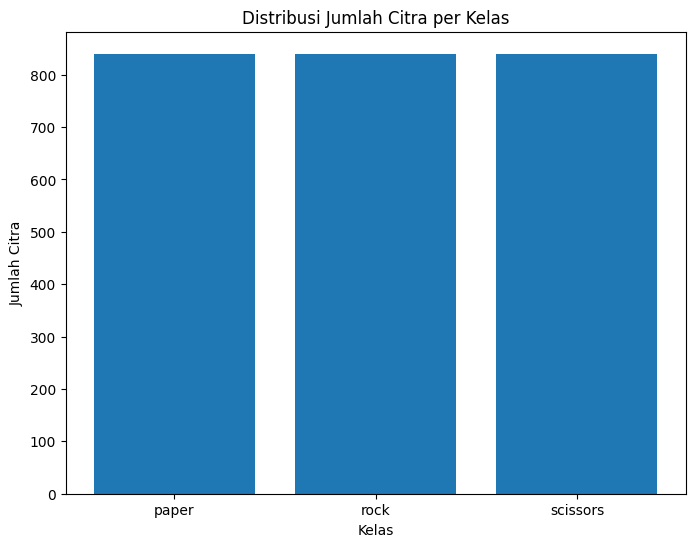

In [ ]:
# Menampilkan distribusi jumlah citra untuk setiap kelas
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, [labels.count(label) for label in unique_labels])
plt.title('Distribusi Jumlah Citra per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Citra')
plt.show()

##5. Lakukan Pre-processing dan Data Augmentation yang menurut kamu memberikan dataset yang lebih efisien

In [ ]:
path_split = r"/content/drive/My Drive/Colab Notebooks/Machine Learning/Modul 5/Dataset/rps/augmented_images"

In [ ]:
train_path = os.path.join(path_split,"train")
val_path = os.path.join(path_split,"val")
test_path = os.path.join(path_split,"test")

In [ ]:
# mengubah skala piksel gambar ke kisaran antara 0 dan 1
datagen = ImageDataGenerator(rescale=1./255,
    # gambar dapat diputar hingga 30 derajat
    rotation_range=30,
    # gambar d apat di geser secara horizon hingga 20% lebarnya
    width_shift_range=0.2,
    # gambar dapat di potong hingga 20% lebarnya
    shear_range=0.2,
    # dapat diperbesar hingga diperkecil hingga 20%
    zoom_range=0.2,
    # membalikan secara horizontal
    horizontal_flip=True,
    # nilai piksel terdekat akan digunakan untuk mengisi celah tersebut.
    fill_mode='nearest', validation_split=0.2)

train_generator = datagen.flow_from_directory(train_path, target_size=(150, 150), batch_size=32, class_mode='categorical')
validation_generator = datagen.flow_from_directory(val_path, target_size=(150, 150), batch_size=32, class_mode='categorical')
test_generator = datagen.flow_from_directory(test_path, target_size=(150, 150), batch_size=32, class_mode='categorical')

Found 1764 images belonging to 3 classes.
Found 630 images belonging to 3 classes.
Found 126 images belonging to 3 classes.


##6. Implementasikan model transfer learning dengan pre-trained architectures models yang anda inginkan menggunakan Tensorflow Keras, PyTorch ataupun lainnya

In [ ]:
# Pre-processing dan Data Augmentation untuk setiap subset (train, validation, test)
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
datagen_val_test = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load dataset
train_generator = datagen_train.flow_from_directory(
    os.path.join(path_split, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen_val_test.flow_from_directory(
    os.path.join(path_split, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen_val_test.flow_from_directory(
    os.path.join(path_split, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1764 images belonging to 3 classes.
Found 630 images belonging to 3 classes.
Found 126 images belonging to 3 classes.


In [ ]:
# Memuat pre-trained model VGG16 tanpa lapisan fully connected
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Membekukan lapisan-lapisan awal (convolutional layers)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Membangun model transfer learning dengan menambahkan lapisan-lapisan kustom
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation='softmax')(x)  # Sesuaikan dengan jumlah kelas

In [ ]:
model = Model(base_model.input, x)

##7. Lakukan Fit Model dengan epoch yang anda tentukan

In [ ]:
# Kompilasi model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Jumlah epoch yang ingin Anda jalankan
num_epochs = 10

In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator
)

Epoch 1/10
56/56 [==============================] - 42s 724ms/step - loss: 0.7235 - accuracy: 0.8702 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 2/10
56/56 [==============================] - 38s 680ms/step - loss: 0.0266 - accuracy: 0.9943 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 3/10
56/56 [==============================] - 38s 674ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/10
56/56 [==============================] - 39s 698ms/step - loss: 0.0102 - accuracy: 0.9994 - val_loss: 6.6264e-04 - val_accuracy: 1.0000
Epoch 5/10
56/56 [==============================] - 39s 698ms/step - loss: 0.0097 - accuracy: 0.9977 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 6/10
56/56 [==============================] - 38s 680ms/step - loss: 0.0104 - accuracy: 0.9983 - val_loss: 4.3551e-04 - val_accuracy: 1.0000
Epoch 7/10
56/56 [==============================] - 39s 697ms/step - loss: 0.0088 - accuracy: 0.9983 - val_loss: 8.7891e-04 - val_accu

In [ ]:
model.save("/content/path/to/save/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##8. Evaluate Model dengan menampilkan Plot, Loss, Accuracy serta Classification Report

In [ ]:
# Menampilkan summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Evaluasi model pada dataset validasi
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

20/20 [==============================] - 6s 270ms/step - loss: 1.8371e-04 - accuracy: 1.0000
Validation Loss: 0.0002, Validation Accuracy: 1.0000


In [ ]:
# Evaluasi model pada dataset test
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

4/4 [==============================] - 5s 2s/step - loss: 1.8582e-04 - accuracy: 1.0000
Test Loss: 0.0002, Test Accuracy: 1.0000


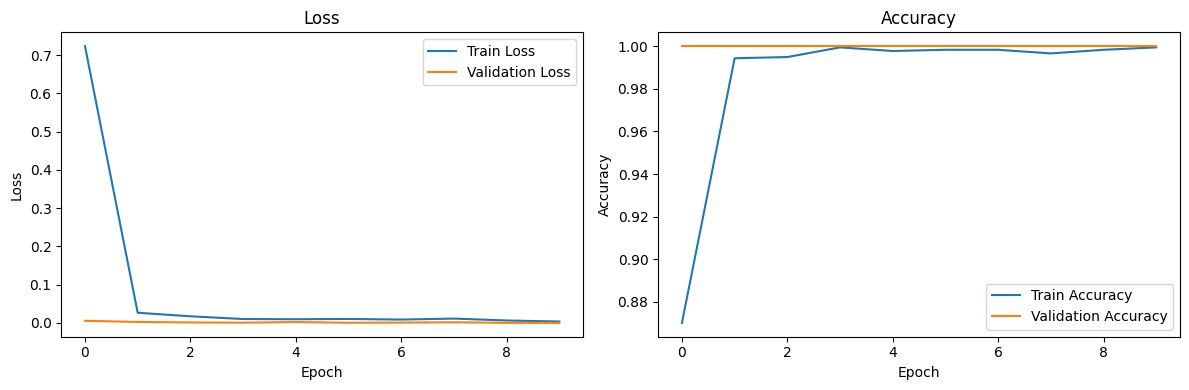

In [ ]:
# Plot Loss dan Accuracy
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Classification Report
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(val_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

20/20 [==============================] - 5s 219ms/step
Classification Report:
              precision    recall  f1-score   support

       paper       0.38      0.38      0.38       210
        rock       0.35      0.35      0.35       210
    scissors       0.35      0.35      0.35       210

    accuracy                           0.36       630
   macro avg       0.36      0.36      0.36       630
weighted avg       0.36      0.36      0.36       630



In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[79 61 70]
 [69 74 67]
 [62 75 73]]


##9. Pilih 10 gambar secara acak pada data test hasil splitting kemudian lakukan predict. Tunjukkan hasilnya kepada asisten.

In [ ]:
# Mengambil 10 gambar secara acak dari data test
random.seed(42)  # Untuk reproducibility
selected_images = random.sample(test_generator.filepaths, 10)

In [ ]:
# Melakukan prediksi pada gambar-gambar tersebut
predictions = []
true_labels = []

In [ ]:
for image_path in selected_images:
    # Memuat dan pre-process gambar
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)
    predictions.append(np.argmax(prediction))

    # Menyimpan true label
    true_label = os.path.basename(os.path.dirname(image_path))
    true_labels.append(true_label)

1/1 [==============================] - 0s 32ms/step


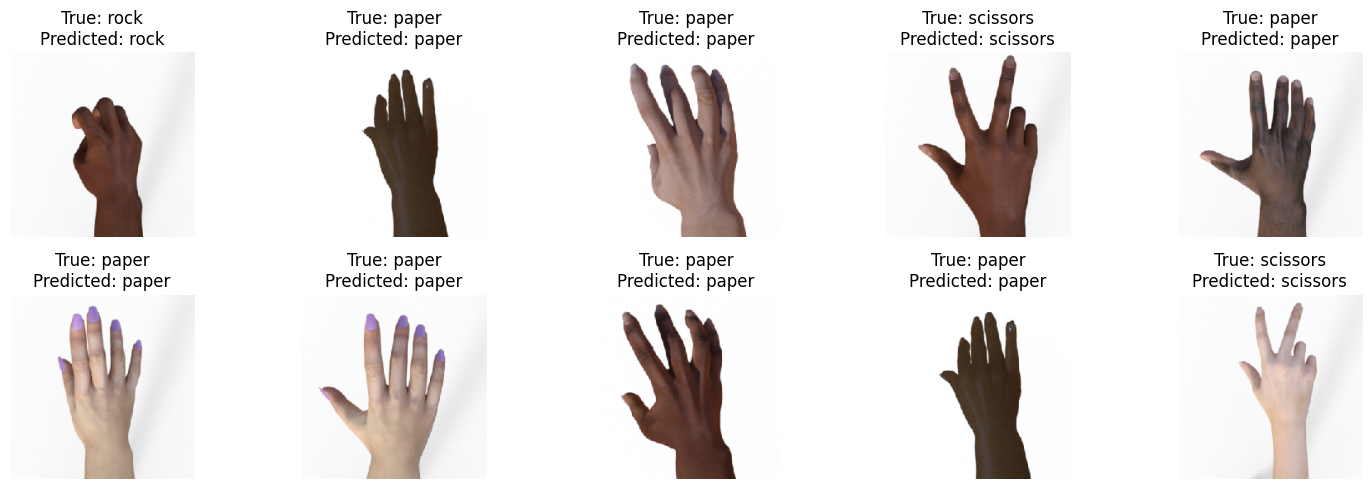

In [ ]:
# Menampilkan gambar dan hasil prediksi
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = load_img(selected_images[i], target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"True: {true_labels[i]}\nPredicted: {class_labels[predictions[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()